IN THIS DOCUMENT...

I will test the preprocessing and visualize the data that we are working with. It is meant a support document to utilize if we want to quickly check the data preprocessing and final database

First... Import statements!

In [23]:

import os
import json
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_curve,roc_auc_score,classification_report)

import matplotlib.pyplot as plt
import shap

import joblib 


For the unofficial database that we have from Kaggle there is already some preprocessing developed so we will use it for a first preprocessing before harmonization and differentiation.

This data comes from three sources:

- Reader_data: Glucose extracts for each week for one user. Contains: Historic Glucose, Scan Glucose, Record Type, Time, ID, Non-nummeric Rapid-Acting Insulin, Rapid-Active Insulin, Non-numeric Food, Carbohydrates, Non-numeric Long-Acting Insulin, Long-Acting Insulin,Note, Strip Glucose, Ketone, Meal Insulin, Correction Insulin, User change Insulin, Previous Time and Updated Time.

But I am only interested in extracting: Time, Historic Glucose, Rapid-Acting Insulin and Long-Acting Insulin.

Since the Scan Glucose has a lot of missing values and Historic Glucose has exactly one record for each 15 minutes intervals (not necessarily taken every 15 minutes but somewhere in the 15 minutes window) I believe it is better to focus on the Historic Glucose Data.

- MySugr_data: It is the data about the meals of the user and contains: Date, Time, Tags, Blood Sugar Measurement, Insulin Injection Units, Basal Injection Units, Insulin Injection Units pump, Insulin of meal, Insulin correction, Temproal Basal Percentage, Temporal basal duration, Meal Carbohydrates, Meal description, Activity Duration, Activity Intensity, Activity description, Steps, Note, Location, Blood Pressure, Body weight, HbA1c, Ketones, Food type and medication.

I am only going to extract: Time and Meal carbohydrates

- fitbit_data: Data from a fitbit band monitoring it contains personal account, physical activity, sleep and stress. I will personally focus first on extracting physical activity and stress.

From these I will use the values of: Time, BPM, total_minutes, distance and calories. And from stress just the subjective stress score as indicated by the user.



In [6]:
df_combined = pd.DataFrame()

In [7]:
def load_reader_dataset():
    # Specify the path for reader data
    #reader_data = "C:/Users/emmxc/OneDrive/Escritorio/FinalProjectThesis/data/reader_data"
    reader_data = "C:/Users/Gebruiker/Documents/GitHub/FinalProjectThesis/data/reader_data"

    exports = [os.path.join(reader_data, export) for export in os.listdir(reader_data)]
    exports.sort(reverse=False)

    df = pd.read_csv(exports[0], sep="\t")
    for export in exports[1:]:
        df = pd.concat([df, pd.read_csv(export, sep="\t")])

    # Exports usually overlap, so drop the duplicates
    df.drop_duplicates(inplace=True)

    # Dropping columns that are not needed
    df.drop(['Non-numeric Food', 'Non-numeric Long-Acting Insulin','Strip Glucose (mmol/L)','Scan Glucose (mmol/L)','Previous Time', 'Updated Time', 'Non-numeric Rapid-Acting Insulin',
             'Notes', 'Ketone (mmol/L)', 'User Change Insulin (units)', 'Record Type','Correction Insulin (units)','Carbohydrates (grams)', 'ID', 'Meal Insulin (units)'],
            axis=1, inplace=True)

    df.rename(columns={'Rapid-Acting Insulin (units)': 'Rapid Insulin',
                       'Long-Acting Insulin (units)': 'Long Insulin'},
              inplace=True)

    df['Time'] = pd.to_datetime(df['Time'], format="%Y/%m/%d %H:%M")
    df.sort_values(by='Time', inplace=True)

    # Only considering Historical Glucose (reliable 15min measurements) - we're not using Scan Glucose column
    df.rename(columns={'Historic Glucose (mmol/L)': 'Glucose'}, inplace=True)

    # Since 2022/01/09 00:00 we use mySugr to keep track of insulin and Carbohydrates, so drop any data after this date
    df.loc[df['Time'] >= "2022/01/09 00:00", ['Rapid Insulin', 'Long Insulin']] = np.nan

    global df_combined
    df_combined = pd.concat([df_combined, df], ignore_index=True)
    return df


def load_mySugr_dataset():
    #mySugr_data = "C:/Users/emmxc/OneDrive/Escritorio/FinalProjectThesis/data/mySugr_data/2022_01_09-2022_04_25_export.csv"
    mySugr_data = "C:/Users/Gebruiker/Documents/GitHub/FinalProjectThesis/data/mySugr_data/2022_01_09-2022_04_25_export.csv"
    mysugr_df = pd.read_csv(mySugr_data, sep=",")

    # Keeping only the relevant columns
    mysugr_df = mysugr_df[['Date', 'Time', 'Meal Carbohydrates (Grams, Factor 1)']]

    mysugr_df.rename(columns={'Meal Carbohydrates (Grams, Factor 1)': 'Carbohydrates'}, inplace=True)

    mysugr_df["Time"] = pd.to_datetime(mysugr_df["Date"] + " " + mysugr_df["Time"], format="%b %d, %Y %I:%M:%S %p")
    mysugr_df.sort_values(by='Time', inplace=True)
    mysugr_df.drop(['Date'], axis=1, inplace=True)

    global df_combined
    df_combined = pd.concat([df_combined, mysugr_df], ignore_index=True)
    return mysugr_df


def read_fitbit_json_export(export_file, export_type):
    with open(export_file, "r") as f:
        j = json.load(f)
    df_read = pd.json_normalize(j)
    df_read["dateTime"] = pd.to_datetime(df_read["dateTime"], format="%m/%d/%y %H:%M:%S")

    if export_type == "heart":
        df_read.rename(columns={"value.bpm": "bpm"}, inplace=True)
        df_read.drop("value.confidence", axis=1, inplace=True)
    elif export_type == "calories":
        df_read.rename(columns={"value": "calories"}, inplace=True)
        df_read["calories"] = df_read["calories"].astype(float)
    elif export_type == "distance":
        df_read.rename(columns={"value": "distance"}, inplace=True)
        df_read["distance"] = df_read["distance"].astype(int)
        # Convert from centimeters to meters
        df_read["distance"] = df_read["distance"] / 100
    else:
        raise Exception("Export type not recognized")
    
    return df_read


def load_fitbit_dataset():
    #fitbit_data = "C:/Users/emmxc/OneDrive/Escritorio/FinalProjectThesis/data/fitbit_data/2022_04_25_all_time_export/Physical Activity"
    fitbit_data = "C:/Users/Gebruiker/Documents/GitHub/FinalProjectThesis/data/fitbit_data/2022_04_25_all_time_export/Physical Activity"

    calories_exports = sorted([os.path.join(fitbit_data, export) for export in os.listdir(fitbit_data) if "calories" in export])
    distance_exports = sorted([os.path.join(fitbit_data, export) for export in os.listdir(fitbit_data) if "distance" in export])
    heart_rate_exports = sorted([os.path.join(fitbit_data, export) for export in os.listdir(fitbit_data) if "heart_rate-" in export and not "resting" in export])

    df_fitbit = read_fitbit_json_export(calories_exports[0], "calories")
    for export in calories_exports[1:]:
        df_fitbit = pd.concat([df_fitbit, read_fitbit_json_export(export, "calories")], ignore_index=True)
    for export in distance_exports:
        df_fitbit = pd.concat([df_fitbit, read_fitbit_json_export(export, "distance")], ignore_index=True)
    for export in heart_rate_exports:
        df_fitbit = pd.concat([df_fitbit, read_fitbit_json_export(export, "heart")], ignore_index=True)

    # Change to 1 minute frequency
    df_fitbit = df_fitbit.set_index('dateTime').resample('1T').agg(
        {'bpm': pd.Series.mean, 'distance': pd.Series.sum, 'calories': pd.Series.sum}).reset_index()

    df_fitbit.rename(columns={"dateTime": "Time"}, inplace=True)
    df_fitbit.sort_values(by='Time', inplace=True)

    global df_combined
    df_combined = pd.concat([df_combined, df_fitbit], ignore_index=True)
    return df_fitbit



In [8]:
load_reader_dataset()
load_mySugr_dataset()
load_fitbit_dataset()

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_24052\10047714.py:98: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_fitbit = df_fitbit.set_index('dateTime').resample('1T').agg(


,Time,bpm,distance,calories
0,2021-11-28 00:00:00,NaN,0.0,1.08
1,2021-11-28 00:01:00,NaN,0.0,1.08
2,2021-11-28 00:02:00,NaN,0.0,1.08
3,2021-11-28 00:03:00,NaN,0.0,1.08
4,2021-11-28 00:04:00,NaN,0.0,1.08
...,...,...,...,...
214382,2022-04-25 21:02:00,NaN,0.0,1.18
214383,2022-04-25 21:03:00,NaN,0.0,1.18
214384,2022-04-25 21:04:00,NaN,0.0,1.18
214385,2022-04-25 21:05:00,NaN,0.0,1.18


In [9]:
# Define the columns
columns_to_plot = ['Glucose','Carbohydrates', 'Rapid Insulin', 'Long Insulin', 'bpm', 'calories', 'distance']

print("\n--- Descriptive Statistics Summary ---")

for column in columns_to_plot:
    print(f"\n[{column}]")

    # Basic stats
    col_data = df_combined[column].dropna()
    total = len(df_combined)
    non_missing = len(col_data)
    missing = total - non_missing
    missing_pct = (missing / total) * 100

    print(f" - Total records: {total}")
    print(f" - Non-missing values: {non_missing}")
    print(f" - Missing values: {missing} ({missing_pct:.2f}%)")
    print(f" - Min: {col_data.min():.2f}" if not col_data.empty else " - Min: N/A")
    print(f" - Max: {col_data.max():.2f}" if not col_data.empty else " - Max: N/A")
    print(f" - Mean: {col_data.mean():.2f}" if not col_data.empty else " - Mean: N/A")
    print(f" - Std Dev: {col_data.std():.2f}" if not col_data.empty else " - Std Dev: N/A")

    # Imbalance 
    zeros = (col_data == 0).sum()
    if zeros > 0:
        zeros_pct = (zeros / non_missing) * 100
        print(f" - Zero values: {zeros} ({zeros_pct:.2f}%)")
    else:
        print(" - No zero values")

HYPER_THRESHOLD = 6.9  # mmol/L
HYPO_THRESHOLD = 3.9    # mmol/L


glucose_data = df_combined['Glucose'].dropna()
total_points = len(glucose_data)

n_hyper = (glucose_data > HYPER_THRESHOLD).sum()
n_hypo = (glucose_data < HYPO_THRESHOLD).sum()
n_normo = total_points - n_hyper - n_hypo

# Calculate percentages
pct_hyper = (n_hyper / total_points) * 100
pct_hypo = (n_hypo / total_points) * 100
pct_normo = (n_normo / total_points) * 100

# Print results
print("\n--- Glucose Episode Breakdown ---")
print(f"Total glucose readings: {total_points}")
print(f"Hyperglycemic episodes: {n_hyper} ({pct_hyper:.2f}%)")
print(f"Hypoglycemic episodes: {n_hypo} ({pct_hypo:.2f}%)")
print(f"Normoglycemic readings: {n_normo} ({pct_normo:.2f}%)")



--- Descriptive Statistics Summary ---

[Glucose]
 - Total records: 265978
 - Non-missing values: 38337
 - Missing values: 227641 (85.59%)
 - Min: 2.20
 - Max: 25.70
 - Mean: 7.77
 - Std Dev: 2.86
 - No zero values

[Carbohydrates]
 - Total records: 265978
 - Non-missing values: 1237
 - Missing values: 264741 (99.53%)
 - Min: 2.00
 - Max: 74.00
 - Mean: 15.96
 - Std Dev: 12.88
 - No zero values

[Rapid Insulin]
 - Total records: 265978
 - Non-missing values: 514
 - Missing values: 265464 (99.81%)
 - Min: 1.00
 - Max: 13.00
 - Mean: 5.11
 - Std Dev: 3.28
 - No zero values

[Long Insulin]
 - Total records: 265978
 - Non-missing values: 80
 - Missing values: 265898 (99.97%)
 - Min: 4.00
 - Max: 15.00
 - Mean: 13.03
 - Std Dev: 2.41
 - No zero values

[bpm]
 - Total records: 265978
 - Non-missing values: 205117
 - Missing values: 60861 (22.88%)
 - Min: 42.12
 - Max: 180.30
 - Mean: 70.91
 - Std Dev: 14.74
 - No zero values

[calories]
 - Total records: 265978
 - Non-missing values: 214387

In [10]:
df_combined.to_csv('preprocessing.csv',sep='\t', index=False )

After the Preprocessing the data looks as shown in the csv file called 'preprocessing.csv'...

There are 166067 rows indexed by time

There are 9 columns: Time, Glucose, Carbohydrates, Rapid Insulin, Long Insulin, bpm, distance, calories and Stress


*HARMONIZING*

Since the data is not collected at the same time moments and we want to do time series analysis we need to harmonize it. Since the most consistent data is the historic glucose and there is a value each 15 minutes, I will harmonize for 15 minute intervals.

HARMONIZING STRATEGIES:
-Glucose: There is just one value each 15 minutes since it is the historic glucose, so that is our value!
- Carbodyrates: Sum the carbs eaten in those 15 minutes
- Rapid Insulin: Sum the insulin injected in those 15 minutes
- Long Insulin: Sum the insulin injected in those 15 minutes
- bpm: Average the bpm in those 15 mintues
- distace: sum the distance in those 15 minutes
- calories: Sum the calories used in those 15 minutes
- stress: average the stress score from those registered within the 15 minutes window

In [11]:

temp = df_combined.copy()

start_time = "2021-11-21 23:45:00"  # Starting point
end_time = temp.index.max()  

time_range = pd.date_range(start=start_time, end=end_time, freq='15T')
temp.set_index('Time', inplace=True)

# Resample the data for 15-minute intervals
df_glu = temp.resample('15T')['Glucose'].mean()
df_car = temp.resample('15T')['Carbohydrates'].sum()
df_rap = temp.resample('15T')['Rapid Insulin'].sum()
df_long = temp.resample('15T')['Long Insulin'].sum()
df_bpm = temp.resample('15T')['bpm'].mean()
df_calories = temp.resample('15T')['calories'].sum()
df_distance = temp.resample('15T')['distance'].sum()

# Create a new DataFrame 
df_har = pd.DataFrame({
    'Time': df_glu.index,
    'Glucose': df_glu,
    'Carbohydrates': df_car,
    'Rapid Insulin': df_rap,
    'Long Insulin': df_long,
    'BPM': df_bpm,
    'Calories': df_calories,
    'Distance': df_distance,
})





C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_24052\2283714506.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start=start_time, end=end_time, freq='15T')
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_24052\2283714506.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_glu = temp.resample('15T')['Glucose'].mean()
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_24052\2283714506.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_car = temp.resample('15T')['Carbohydrates'].sum()
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_24052\2283714506.py:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_rap = temp.resample('15T')['Rapid Insulin'].sum()
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_24052\2283714506.py:13: FutureWa

In [12]:

first_month_mask = (df_har['Time'] >= '2021-12-01') & (df_har['Time'] < '2022-01-01')
df_first = df_har[first_month_mask].reset_index(drop=True)


third_month_mask = (df_har['Time'] >= '2022-02-01') & (df_har['Time'] < '2022-03-01')
df_third = df_har[third_month_mask][['Carbohydrates', 'BPM']].reset_index(drop=True)

min_len = min(len(df_first), len(df_third))
df_first = df_first.iloc[:min_len]
df_third = df_third.iloc[:min_len]


df_first['Carbohydrates'] = df_third['Carbohydrates'].values
df_first['BPM'] = df_third['BPM'].values

df = df_first.copy()

Let's do some quick visualization with matplotlib

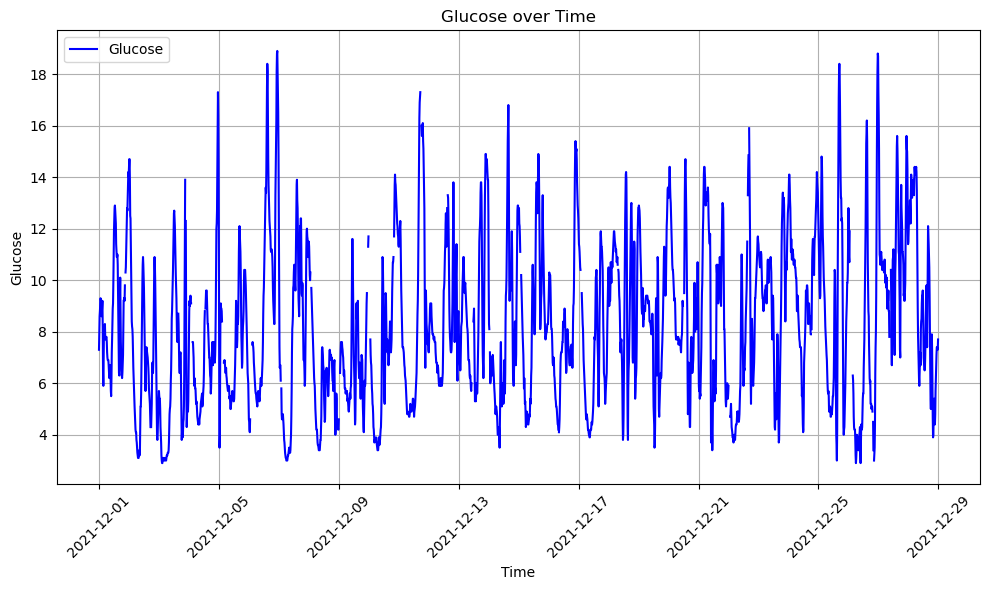

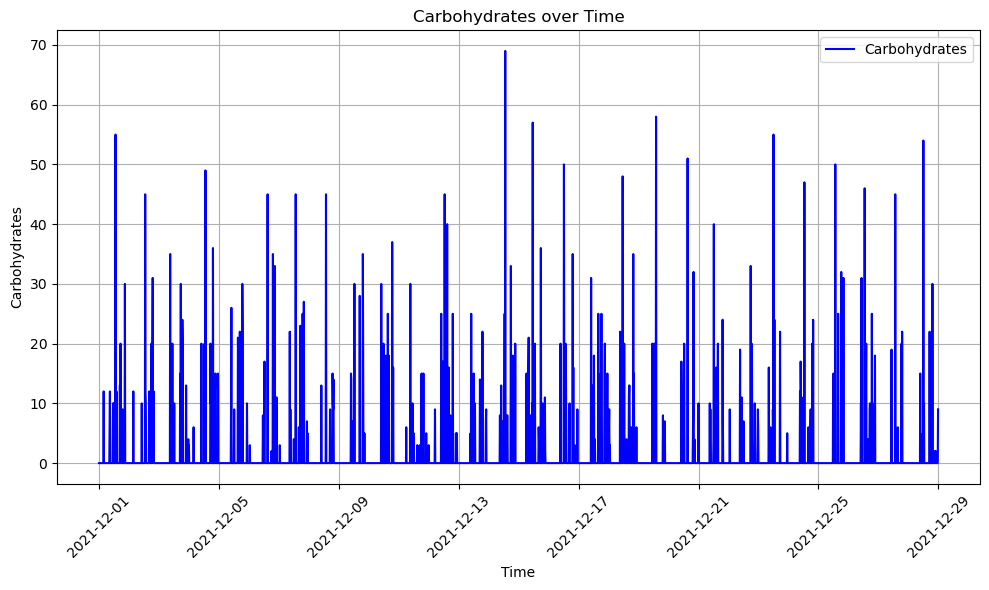

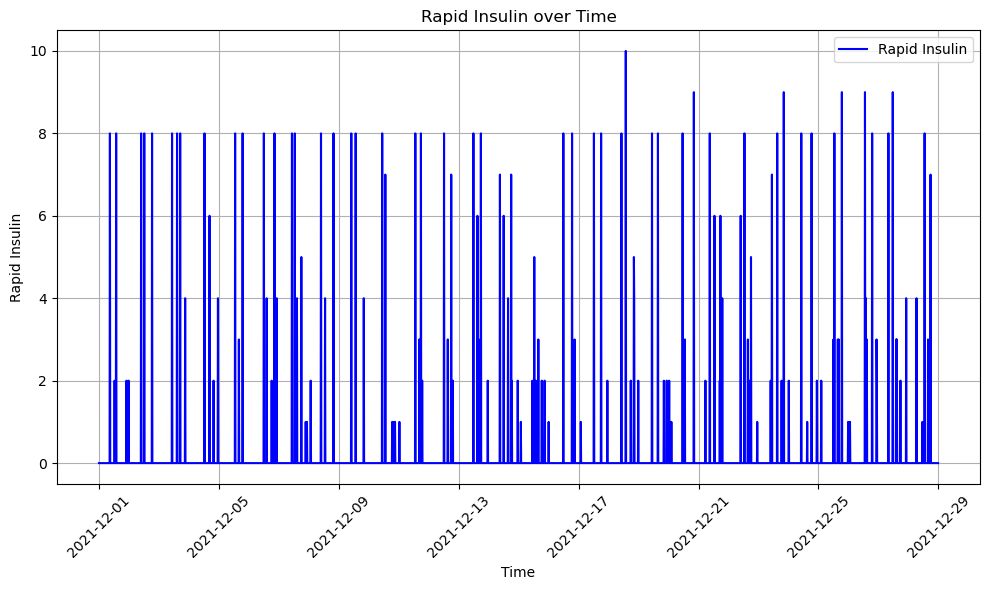

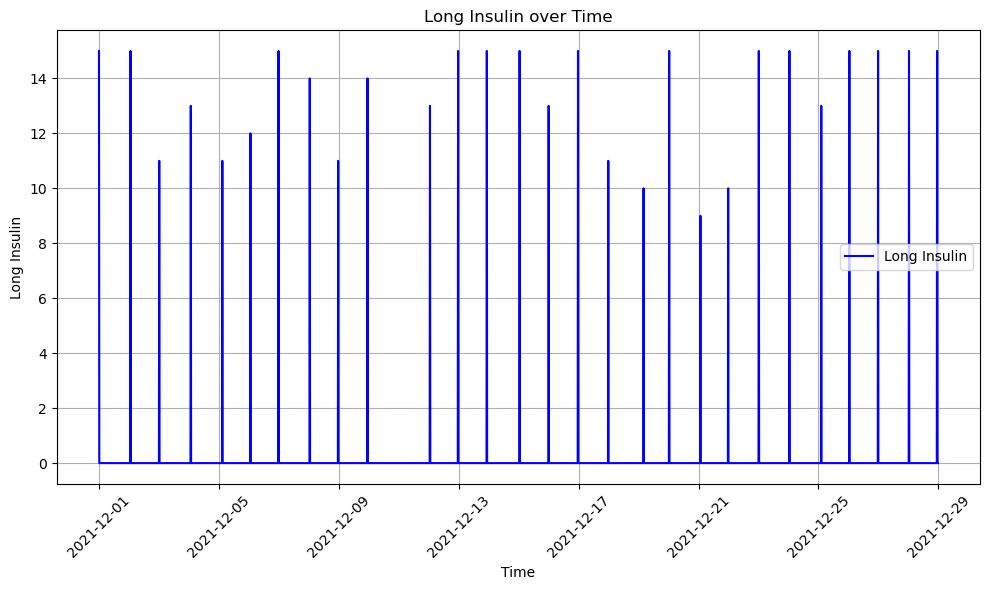

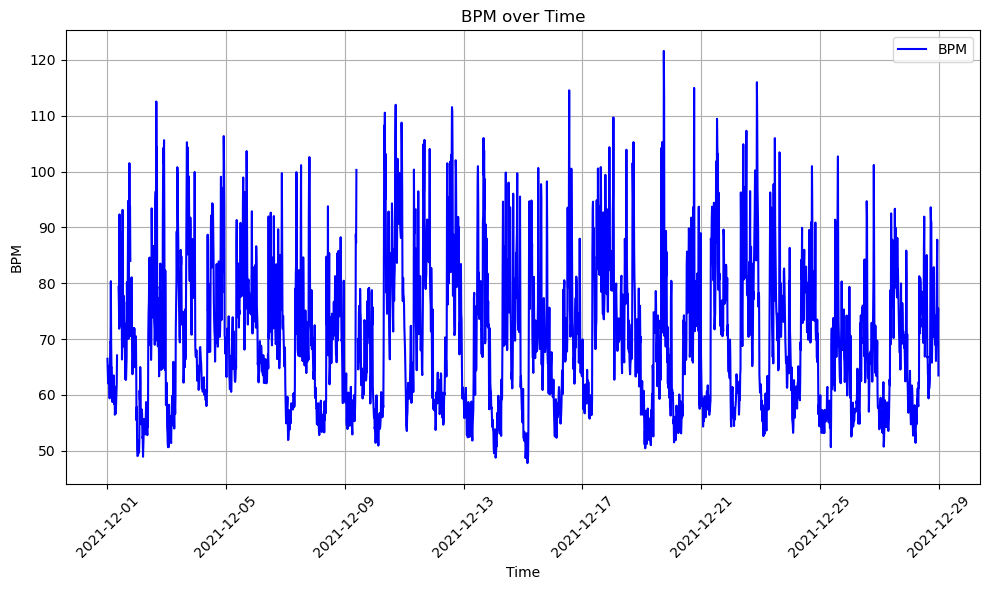

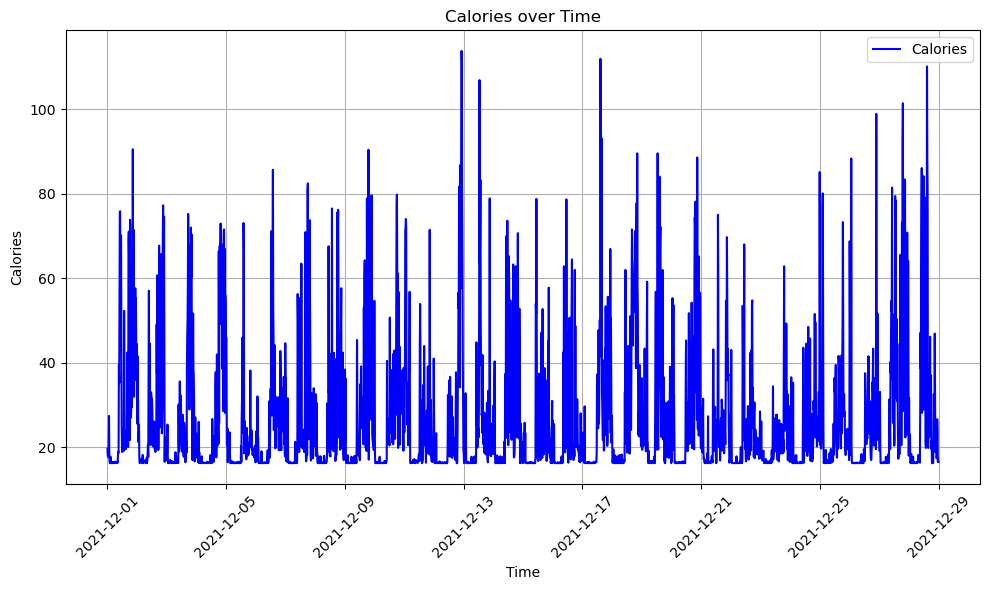

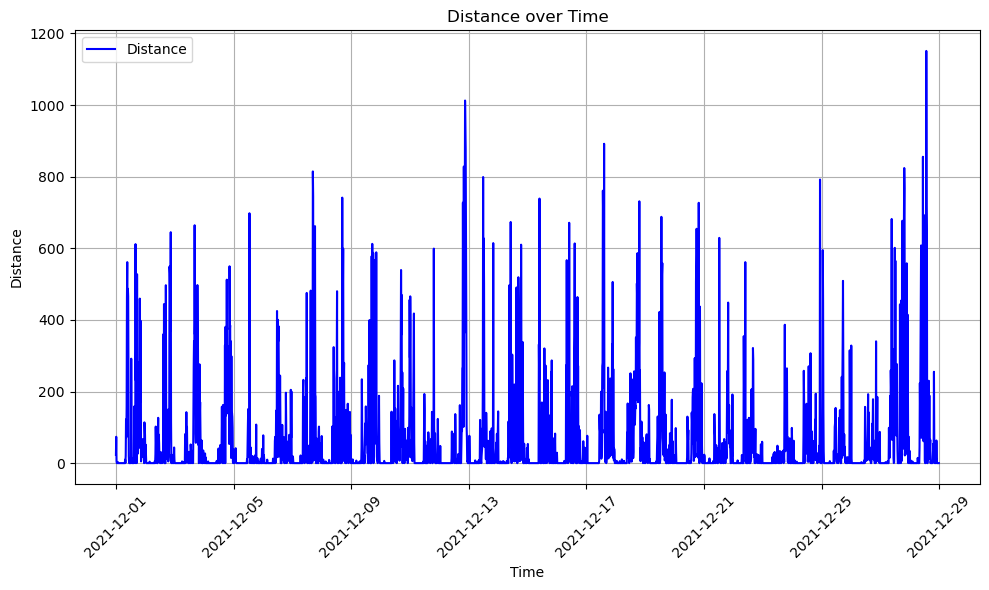

In [13]:

# Define the columns
columns_to_plot = ['Glucose','Carbohydrates', 'Rapid Insulin', 'Long Insulin', 'BPM', 'Calories', 'Distance']

for column in columns_to_plot:
    plt.figure(figsize=(10, 6)) 
    plt.plot(df['Time'], df[column], label=column, color='b')  
    plt.title(f'{column} over Time')
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [14]:
print("\n--- Descriptive Statistics harmonized Summary ---")

for column in columns_to_plot:
    print(f"\n[{column}]")

    # Basic stats
    col_data = df[column].dropna()
    total = len(df)
    non_missing = len(col_data)
    missing = total - non_missing
    missing_pct = (missing / total) * 100

    print(f" - Total records: {total}")
    print(f" - Non-missing values: {non_missing}")
    print(f" - Missing values: {missing} ({missing_pct:.2f}%)")
    print(f" - Min: {col_data.min():.2f}" if not col_data.empty else " - Min: N/A")
    print(f" - Max: {col_data.max():.2f}" if not col_data.empty else " - Max: N/A")
    print(f" - Mean: {col_data.mean():.2f}" if not col_data.empty else " - Mean: N/A")
    print(f" - Std Dev: {col_data.std():.2f}" if not col_data.empty else " - Std Dev: N/A")

    # Imbalance / zero-value detection
    zeros = (col_data == 0).sum()
    if zeros > 0:
        zeros_pct = (zeros / non_missing) * 100
        print(f" - Zero values: {zeros} ({zeros_pct:.2f}%)")
    else:
        print(" - No zero values")

    # Spike detection (optional for e.g., Glucose or BPM)
    if column in ['Glucose', 'BPM']:
        spikes = col_data.diff().abs() > col_data.std()
        spike_count = spikes.sum()
        print(f" - Sudden changes (spikes): {spike_count}")


HYPER_THRESHOLD = 6.9  
HYPO_THRESHOLD = 3.9    



glucose_data = df['Glucose'].dropna()
total_points = len(glucose_data)

n_hyper = (glucose_data > HYPER_THRESHOLD).sum()
n_hypo = (glucose_data < HYPO_THRESHOLD).sum()
n_normo = total_points - n_hyper - n_hypo


pct_hyper = (n_hyper / total_points) * 100
pct_hypo = (n_hypo / total_points) * 100
pct_normo = (n_normo / total_points) * 100


print("\n--- Glucose Episode Breakdown ---")
print(f"Total glucose readings: {total_points}")
print(f"Hyperglycemic episodes: {n_hyper} ({pct_hyper:.2f}%)")
print(f"Hypoglycemic episodes: {n_hypo} ({pct_hypo:.2f}%)")
print(f"Normoglycemic readings: {n_normo} ({pct_normo:.2f}%)")


--- Descriptive Statistics harmonized Summary ---

[Glucose]
 - Total records: 2688
 - Non-missing values: 2613
 - Missing values: 75 (2.79%)
 - Min: 2.90
 - Max: 18.90
 - Mean: 8.29
 - Std Dev: 3.11
 - No zero values
 - Sudden changes (spikes): 12

[Carbohydrates]
 - Total records: 2688
 - Non-missing values: 2688
 - Missing values: 0 (0.00%)
 - Min: 0.00
 - Max: 69.00
 - Mean: 1.87
 - Std Dev: 6.64
 - Zero values: 2380 (88.54%)

[Rapid Insulin]
 - Total records: 2688
 - Non-missing values: 2688
 - Missing values: 0 (0.00%)
 - Min: 0.00
 - Max: 10.00
 - Mean: 0.25
 - Std Dev: 1.24
 - Zero values: 2547 (94.75%)

[Long Insulin]
 - Total records: 2688
 - Non-missing values: 2688
 - Missing values: 0 (0.00%)
 - Min: 0.00
 - Max: 15.00
 - Mean: 0.14
 - Std Dev: 1.37
 - Zero values: 2660 (98.96%)

[BPM]
 - Total records: 2688
 - Non-missing values: 2673
 - Missing values: 15 (0.56%)
 - Min: 47.80
 - Max: 121.60
 - Mean: 70.60
 - Std Dev: 12.87
 - No zero values
 - Sudden changes (spikes): 

Now we do the kinetics for insulin and carbohydrates and save it in kinetics csv file and the final dataframe called DF.

In [15]:

df_kinetics = df.copy()

steps = len(df_kinetics)
dt = 1 


rapid_injection = df_kinetics['Rapid Insulin'].fillna(0).values
long_injection = df_kinetics['Long Insulin'].fillna(0).values


def insulin_absorption_model(rapid_array, long_array, ka1_r=0.04, ka2_r=0.06, ka1_l=0.01, ka2_l=0.015):
    Q1_r = np.zeros(steps)
    Q2_r = np.zeros(steps)
    Q1_l = np.zeros(steps)
    Q2_l = np.zeros(steps)

    for i in range(1, steps):
        inj_r = rapid_array[i]
        inj_l = long_array[i]

        dQ1_r = (-ka1_r * Q1_r[i-1] + inj_r) * dt
        dQ2_r = (ka1_r * Q1_r[i-1] - ka2_r * Q2_r[i-1]) * dt

        dQ1_l = (-ka1_l * Q1_l[i-1] + inj_l) * dt
        dQ2_l = (ka1_l * Q1_l[i-1] - ka2_l * Q2_l[i-1]) * dt

        Q1_r[i] = Q1_r[i-1] + dQ1_r
        Q2_r[i] = Q2_r[i-1] + dQ2_r

        Q1_l[i] = Q1_l[i-1] + dQ1_l
        Q2_l[i] = Q2_l[i-1] + dQ2_l

    return Q2_r + Q2_l  # Insulin on board 


df_kinetics['Insulin on board'] = insulin_absorption_model(rapid_injection, long_injection)
df_kinetics['Insulin absorption'] = insulin_absorption_model(rapid_injection, long_injection)


In [16]:
def carbs_to_cob(df, carb_col='Carbohydrates', dt=15, t_max=40):
    Q1 = np.zeros(len(df))
    Q2 = np.zeros(len(df))
    
    for i in range(1, len(df)):
    
        c = df.iloc[i - 1][carb_col]
        
        dQ1 = (-Q1[i - 1] / t_max) * dt + 0.8 * c

        dQ2 = (Q1[i - 1] / t_max - Q2[i - 1] / t_max) * dt



        Q1[i] = Q1[i - 1] + dQ1
        Q2[i] = Q2[i - 1] + dQ2

    df['COB'] = Q2
    return df


df_kinetics = carbs_to_cob(df_kinetics)

In [17]:

df_kinetics['Minutes since last Carbs'] = pd.NA
df_kinetics['Minutes since last Insulin'] = pd.NA
df_kinetics['Last Insulin Type'] = pd.NA


last_carbs_index = None
last_rapid_index = None
last_long_index = None


for i in range(len(df_kinetics)):
    time_i = df_kinetics.at[i, 'Time']

    # Carbs
    if df_kinetics.at[i, 'Carbohydrates'] > 0:
        last_carbs_index = i
        df_kinetics.at[i, 'Minutes since last Carbs'] = 0
    elif last_carbs_index is not None:
        time_last_carbs = df_kinetics.at[last_carbs_index, 'Time']
        delta = (time_i - time_last_carbs).total_seconds() / 60
        df_kinetics.at[i, 'Minutes since last Carbs'] = int(delta)

    # Insulin
    insulin_type = None
    if df_kinetics.at[i, 'Rapid Insulin'] > 0:
        last_rapid_index = i
        insulin_type = "Rapid"
        df_kinetics.at[i, 'Minutes since last Insulin'] = 0
        df_kinetics.at[i, 'Last Insulin Type'] = "Rapid"
    elif df_kinetics.at[i, 'Long Insulin'] > 0:
        last_long_index = i
        insulin_type = "Long"
        df_kinetics.at[i, 'Minutes since last Insulin'] = 0
        df_kinetics.at[i, 'Last Insulin Type'] = "Long"
    else:
        # Determine most recent insulin injection type
        if last_rapid_index is not None and last_long_index is not None:
            time_rapid = df_kinetics.at[last_rapid_index, 'Time']
            time_long = df_kinetics.at[last_long_index, 'Time']
            if time_rapid > time_long:
                delta = (time_i - time_rapid).total_seconds() / 60
                df_kinetics.at[i, 'Minutes since last Insulin'] = int(delta)
                df_kinetics.at[i, 'Last Insulin Type'] = "Rapid"
            else:
                delta = (time_i - time_long).total_seconds() / 60
                df_kinetics.at[i, 'Minutes since last Insulin'] = int(delta)
                df_kinetics.at[i, 'Last Insulin Type'] = "Long"
        elif last_rapid_index is not None:
            delta = (time_i - df_kinetics.at[last_rapid_index, 'Time']).total_seconds() / 60
            df_kinetics.at[i, 'Minutes since last Insulin'] = int(delta)
            df_kinetics.at[i, 'Last Insulin Type'] = "Rapid"
        elif last_long_index is not None:
            delta = (time_i - df_kinetics.at[last_long_index, 'Time']).total_seconds() / 60
            df_kinetics.at[i, 'Minutes since last Insulin'] = int(delta)
            df_kinetics.at[i, 'Last Insulin Type'] = "Long"


df_kinetics.to_csv('final.csv', sep='\t', index=False)

TRAINING THE RANDOM FOREST:

Data prep:
Hyperglycemia_future = 1 if glucose at t+30min > 6.9

Hypoglycemia_future = 1 if glucose at t+30min < 3.9

Glucose_future = glucose at t+30min

Use current features at time t: BPM, Calories, Distance, Insulin on board, COB, Glucose

We want to train two separate machine learning models that:

Take current + past 2 hours of data as input

Predict the probability of hyperglycemia or hypoglycemia occurring 15 minutes into the future

This is useful for proactive alerts in diabetes monitoring or glucose trend prediction.

In [78]:
features = ['Glucose', 'BPM', 'Calories', 'Distance', 'Insulin on board', 'COB']
sampling_interval = 5  # minutes per row
lookback_steps = 24    # past 2 hours if 5-min intervals
hyper_threshold = 6.9
hypo_threshold = 3.9
prediction_minutes_list = [15, 30, 60, 120]  # ⬅️ Each will train/run separately

# FUNCTION TO TRAIN & EVALUATE

def train_and_evaluate_model(prediction_minutes_ahead):
    print(f"\n\n==========================")
    print(f"⏱ Prediction: {prediction_minutes_ahead} minutes ahead")
    print(f"==========================")

    # 1. Compute future steps for shifting
    future_steps = int(prediction_minutes_ahead / sampling_interval)

    # 2. Prepare dataset
    df = df_kinetics.copy()
    df['Glucose_future'] = df['Glucose'].shift(-future_steps)
    df['Hyperglycemia_future'] = (df['Glucose_future'] > hyper_threshold).astype(int)
    df['Hypoglycemia_future'] = (df['Glucose_future'] < hypo_threshold).astype(int)

    # 3. Extract rolling window features
    X_rows, y_hyper, y_hypo = [], [], []
    for i in range(lookback_steps, len(df) - future_steps):
        window = df.iloc[i - lookback_steps : i][features]
        if window.isnull().values.any():
            continue
        X_rows.append(window.values.flatten())
        y_hyper.append(df.iloc[i]['Hyperglycemia_future'])
        y_hypo.append(df.iloc[i]['Hypoglycemia_future'])

    X = np.array(X_rows)
    y_hyper = np.array(y_hyper)
    y_hypo = np.array(y_hypo)

    # 4. Preprocess
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    X_processed = pipeline.fit_transform(X)

    # 5. Train/Test split
    X_train_hyper, X_test_hyper, y_train_hyper, y_test_hyper = train_test_split(X_processed, y_hyper, test_size=0.2, random_state=42)
    X_train_hypo, X_test_hypo, y_train_hypo, y_test_hypo = train_test_split(X_processed, y_hypo, test_size=0.2, random_state=42)

    # 6. Train models
    clf_hyper = RandomForestClassifier(n_estimators=200, random_state=42)
    clf_hyper.fit(X_train_hyper, y_train_hyper)

    clf_hypo = RandomForestClassifier(n_estimators=200, random_state=42)
    clf_hypo.fit(X_train_hypo, y_train_hypo)

    # 7. Predictions
    y_pred_hyper = clf_hyper.predict(X_test_hyper)
    y_proba_hyper = clf_hyper.predict_proba(X_test_hyper)[:, 1]

    y_pred_hypo = clf_hypo.predict(X_test_hypo)
    y_proba_hypo = clf_hypo.predict_proba(X_test_hypo)[:, 1]

    # 8. Evaluation
    print("\n Hyperglycemia Classification Report:")
    print(classification_report(y_test_hyper, y_pred_hyper))

    print("\n Hypoglycemia Classification Report:")
    print(classification_report(y_test_hypo, y_pred_hypo))

    fpr_hyper, tpr_hyper, _ = roc_curve(y_test_hyper, y_proba_hyper)
    fpr_hypo, tpr_hypo, _ = roc_curve(y_test_hypo, y_proba_hypo)

    auc_hyper = roc_auc_score(y_test_hyper, y_proba_hyper)
    auc_hypo = roc_auc_score(y_test_hypo, y_proba_hypo)

    # 9. Plot ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_hyper, tpr_hyper, label=f"Hyperglycemia AUC = {auc_hyper:.2f}")
    plt.plot(fpr_hypo, tpr_hypo, label=f"Hypoglycemia AUC = {auc_hypo:.2f}")
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title(f'ROC Curve: {prediction_minutes_ahead}-min Prediction')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Final return
    return {
        'interval': prediction_minutes_ahead,
        'clf_hyper': clf_hyper,
        'clf_hypo': clf_hypo,
        'imputer': pipeline.named_steps['imputer'],
        'scaler': pipeline.named_steps['scaler']
    }

We evaluate models using:

Classification Report (precision, recall, F1-score)

ROC Curve and AUC Score – show how well the model separates risk/no-risk cases

These metrics help us understand whether our model is clinically useful and how confident it is in risk predictions.

HORIZON OF 15 MINUTES, 30 MINUTES, 60 MINUTES AND 120 MINUTES




⏱ Prediction: 15 minutes ahead

 Hyperglycemia Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.72      0.81       134
           1       0.86      0.97      0.91       231

    accuracy                           0.88       365
   macro avg       0.90      0.85      0.86       365
weighted avg       0.89      0.88      0.88       365


 Hypoglycemia Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       357
           1       1.00      0.62      0.77         8

    accuracy                           0.99       365
   macro avg       1.00      0.81      0.88       365
weighted avg       0.99      0.99      0.99       365



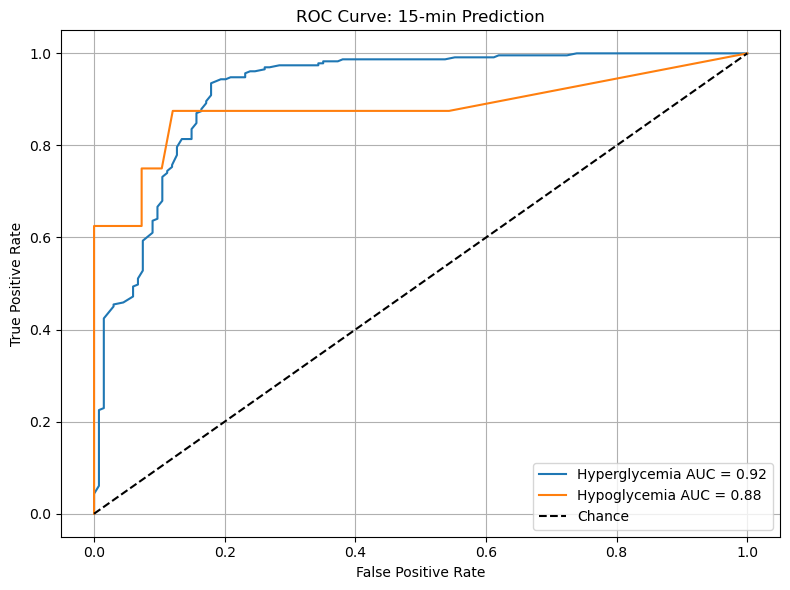



⏱ Prediction: 30 minutes ahead

 Hyperglycemia Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.65      0.78       130
           1       0.84      1.00      0.91       234

    accuracy                           0.87       364
   macro avg       0.91      0.82      0.84       364
weighted avg       0.89      0.87      0.86       364


 Hypoglycemia Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       356
           1       1.00      0.50      0.67         8

    accuracy                           0.99       364
   macro avg       0.99      0.75      0.83       364
weighted avg       0.99      0.99      0.99       364



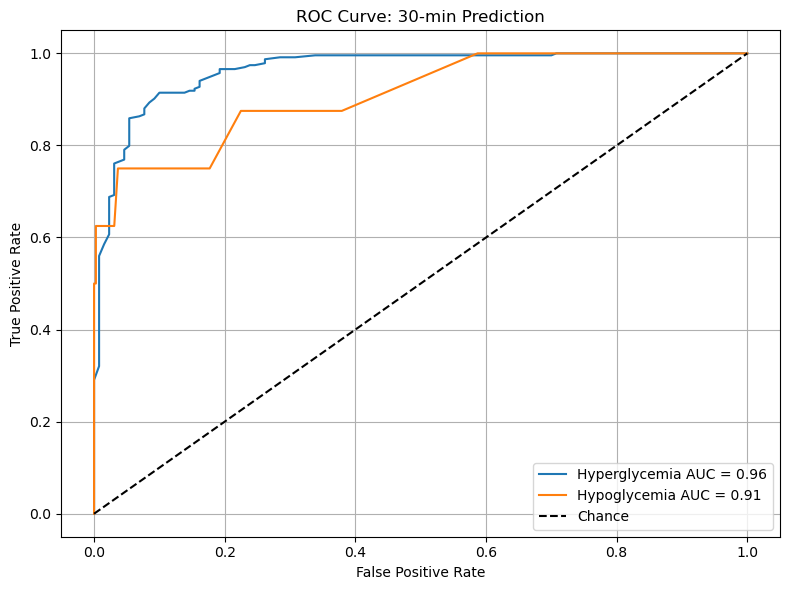



⏱ Prediction: 60 minutes ahead

 Hyperglycemia Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.52      0.66       126
           1       0.79      0.98      0.88       237

    accuracy                           0.82       363
   macro avg       0.86      0.75      0.77       363
weighted avg       0.84      0.82      0.80       363


 Hypoglycemia Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       356
           1       1.00      0.57      0.73         7

    accuracy                           0.99       363
   macro avg       1.00      0.79      0.86       363
weighted avg       0.99      0.99      0.99       363



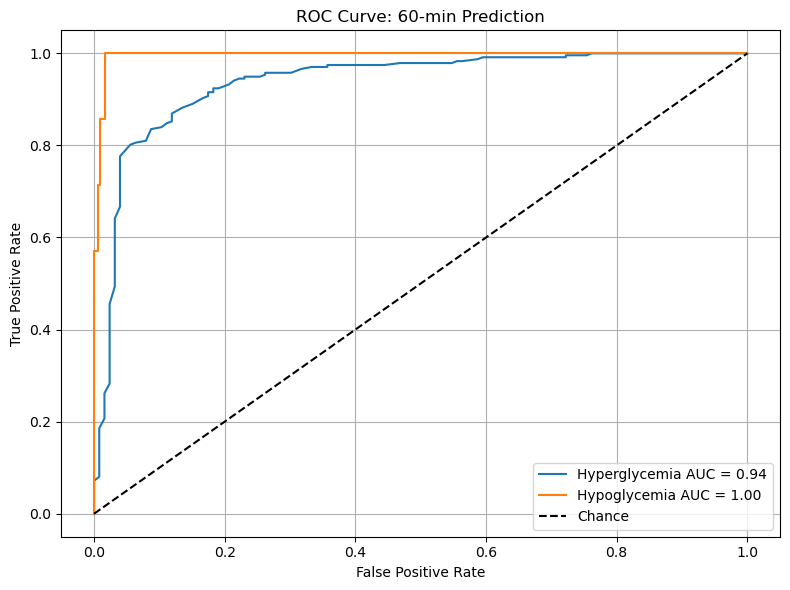



⏱ Prediction: 120 minutes ahead

 Hyperglycemia Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.62      0.74       155
           1       0.77      0.96      0.85       206

    accuracy                           0.81       361
   macro avg       0.84      0.79      0.80       361
weighted avg       0.83      0.81      0.80       361


 Hypoglycemia Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       351
           1       0.00      0.00      0.00        10

    accuracy                           0.97       361
   macro avg       0.49      0.50      0.49       361
weighted avg       0.95      0.97      0.96       361



c:\Users\Gebruiker\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gebruiker\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gebruiker\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


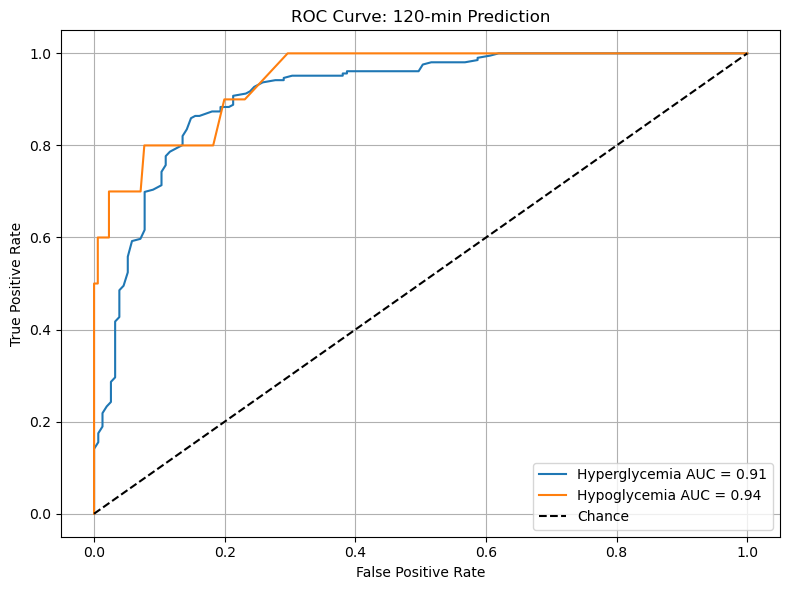

In [79]:
# Dictionary to hold models for each interval
trained_models = {}

for interval in prediction_minutes_list:
    results = train_and_evaluate_model(interval)
    trained_models[interval] = {
        'clf_class': results['clf_hyper'],  # you can switch to 'clf_hypo' for hypo SHAP later
        'clf_reg': results['clf_hyper'],    # temporary: use same model for regression for now
        'imputer': results['imputer'],
        'scaler': results['scaler'],
    }


In [80]:
def predict_from_now(models_dict, df_kinetics, features, lookback_steps=24):
    latest_data = df_kinetics.copy().reset_index(drop=True)
    predictions = {}

    # Extract the last `lookback_steps` rows for the rolling window
    window = latest_data.iloc[-lookback_steps:][features]
    if window.isnull().values.any():
        print("❌ Not enough complete recent data to make predictions.")
        return None

    # Flatten and preprocess the input
    X_now = window.values.flatten().reshape(1, -1)

    for interval, model_pack in models_dict.items():
        imputer = model_pack['imputer']
        scaler = model_pack['scaler']
        clf_hyper = model_pack['clf_hyper']
        clf_hypo = model_pack['clf_hypo']

        # Preprocess input
        X_now_imputed = imputer.transform(X_now)
        X_now_scaled = scaler.transform(X_now_imputed)

        # Predict probabilities
        hyper_proba = clf_hyper.predict_proba(X_now_scaled)[0][1]
        hypo_proba = clf_hypo.predict_proba(X_now_scaled)[0][1]

        predictions[interval] = {
            'Hyperglycemia Probability': hyper_proba,
            'Hypoglycemia Probability': hypo_proba
        }

    return predictions




⏱ Prediction: 15 minutes ahead

 Hyperglycemia Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.72      0.81       134
           1       0.86      0.97      0.91       231

    accuracy                           0.88       365
   macro avg       0.90      0.85      0.86       365
weighted avg       0.89      0.88      0.88       365


 Hypoglycemia Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       357
           1       1.00      0.62      0.77         8

    accuracy                           0.99       365
   macro avg       1.00      0.81      0.88       365
weighted avg       0.99      0.99      0.99       365



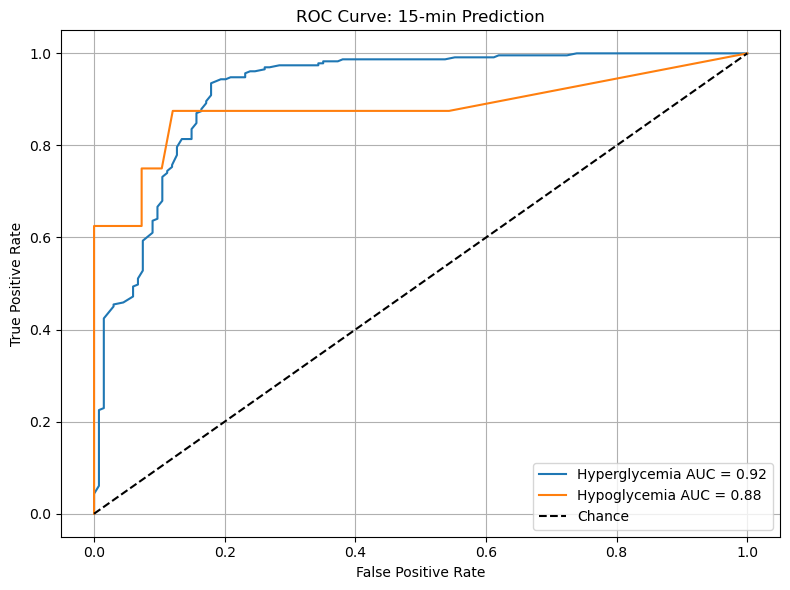



⏱ Prediction: 30 minutes ahead

 Hyperglycemia Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.65      0.78       130
           1       0.84      1.00      0.91       234

    accuracy                           0.87       364
   macro avg       0.91      0.82      0.84       364
weighted avg       0.89      0.87      0.86       364


 Hypoglycemia Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       356
           1       1.00      0.50      0.67         8

    accuracy                           0.99       364
   macro avg       0.99      0.75      0.83       364
weighted avg       0.99      0.99      0.99       364



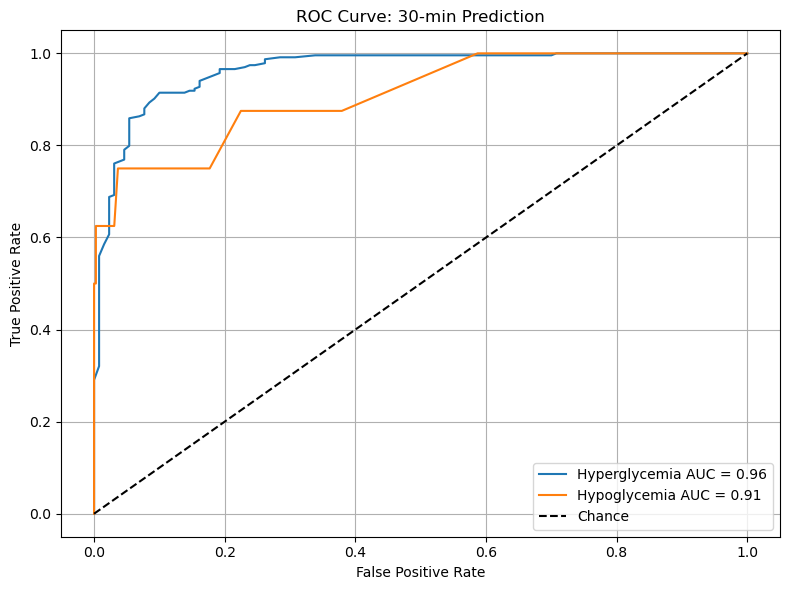



⏱ Prediction: 60 minutes ahead

 Hyperglycemia Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.52      0.66       126
           1       0.79      0.98      0.88       237

    accuracy                           0.82       363
   macro avg       0.86      0.75      0.77       363
weighted avg       0.84      0.82      0.80       363


 Hypoglycemia Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       356
           1       1.00      0.57      0.73         7

    accuracy                           0.99       363
   macro avg       1.00      0.79      0.86       363
weighted avg       0.99      0.99      0.99       363



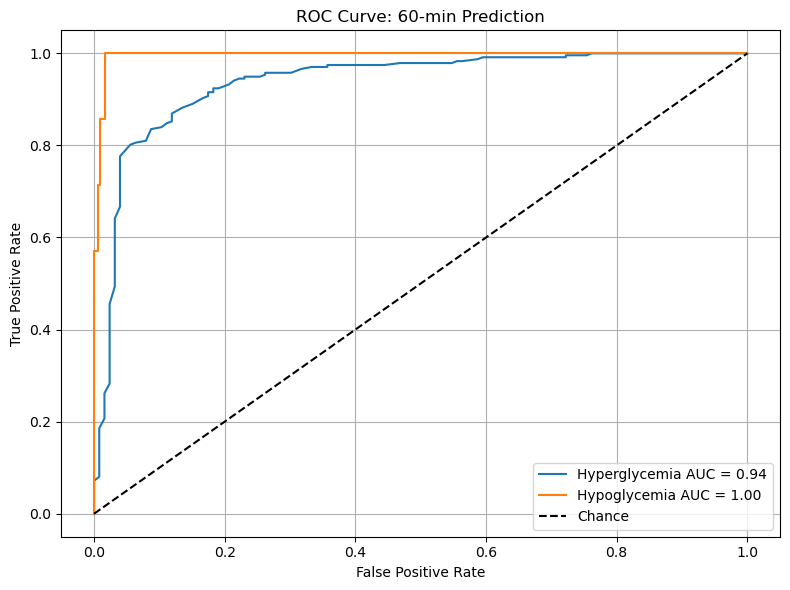



⏱ Prediction: 120 minutes ahead

 Hyperglycemia Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.62      0.74       155
           1       0.77      0.96      0.85       206

    accuracy                           0.81       361
   macro avg       0.84      0.79      0.80       361
weighted avg       0.83      0.81      0.80       361


 Hypoglycemia Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       351
           1       0.00      0.00      0.00        10

    accuracy                           0.97       361
   macro avg       0.49      0.50      0.49       361
weighted avg       0.95      0.97      0.96       361



c:\Users\Gebruiker\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gebruiker\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gebruiker\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


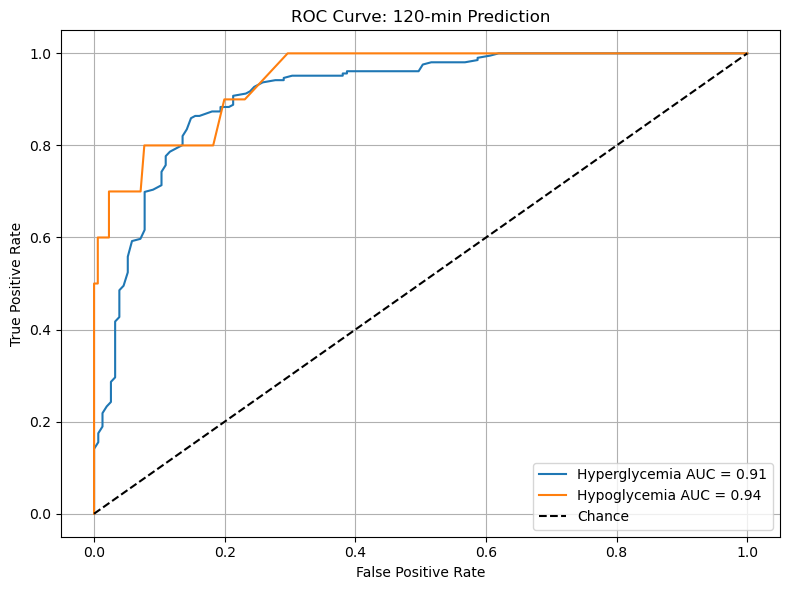

KeyError: 'clf_hyper'

In [ ]:
model_results = {}
for mins in [15, 30, 60, 120]:
    model_results[mins] = train_and_evaluate_model(mins)

# Predict from the most recent data
now_predictions = predict_from_now(trained_models, df_kinetics, features)

# Print results
for interval, probs in now_predictions.items():
    print(f"\n🕒 Prediction for +{interval} min:")
    print(f"  🔺 Hyperglycemia Risk: {probs['Hyperglycemia Probability']:.2%}")
    print(f"  🔻 Hypoglycemia Risk: {probs['Hypoglycemia Probability']:.2%}")


OPERATE THE SHAP VALUES TO GET A DESCRIPTIVE TEXT

In [ ]:
# Define the feature names explicitly
feature_names = ["bpm", "calories", "distance", "insulin", "carbs"]

# Prepare storage
intervals = []
features = []
hyper_values = []
hypo_values = []

# Loop through rows
for _, row in shap_summary_df.iterrows():
    interval = row['Interval']
    shap_pairs = row['SHAP Values'][0]

    for feature_idx, (hyper, hypo) in enumerate(shap_pairs):
        feature_name = feature_names[feature_idx] if feature_idx < len(feature_names) else f"Feature {feature_idx + 1}"
        intervals.append(interval)
        features.append(feature_name)
        hyper_values.append(hyper)
        hypo_values.append(hypo)

# Create the DataFrame
shap_df = pd.DataFrame({
    "Interval": intervals,
    "Feature": features,
    "Hyper Value": hyper_values,
    "Hypo Value": hypo_values
})

# Convert to HTML
html_table = shap_df.to_html(index=False)

# Save to file (optional)
with open("shap_values.html", "w", encoding="utf-8") as f:
    f.write(html_table)

print("SHAP table with named features generated.")

SHAP table with named features generated.


In [ ]:
def top_3_overall(df):
    """
    Returns the top 3 rows with highest absolute Hyper and Hypo SHAP values.

    Args:
        df (pd.DataFrame): SHAP value DataFrame with 'Hyper Value' and 'Hypo Value'.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: (top_3_hyper, top_3_hypo)
    """
    top3_hyper = df.reindex(df['Hyper Value'].abs().sort_values(ascending=False).index).head(3)
    top3_hypo = df.reindex(df['Hypo Value'].abs().sort_values(ascending=False).index).head(3)
    return top3_hyper, top3_hypo


top3_hyper_df, top3_hypo_df = top_3_overall(shap_df)

# Optionally print or save
print("Top 3 Hyper SHAP Values:")
print(top3_hyper_df)

print("\nTop 3 Hypo SHAP Values:")
print(top3_hypo_df)

# Or convert to HTML for templating
html_hyper_top3 = top3_hyper_df.to_html(index=False)
html_hypo_top3 = top3_hypo_df.to_html(index=False)

Top 3 Hyper SHAP Values:
Empty DataFrame
Columns: [Interval, Feature, Hyper Value, Hypo Value]
Index: []

Top 3 Hypo SHAP Values:
Empty DataFrame
Columns: [Interval, Feature, Hyper Value, Hypo Value]
Index: []


In [ ]:
def top_3_overall_as_descriptive_text(df):
    """
    Returns the top 3 rows with highest absolute Hyper and Hypo SHAP values in a descriptive text format.

    Args:
        df (pd.DataFrame): SHAP value DataFrame with 'Hyper Value' and 'Hypo Value'.

    Returns:
        str: Descriptive text representation of top 3 Hyper and Hypo SHAP values.
    """
    # Get top 3 for Hyper and Hypo separately
    top3_hyper = df.reindex(df['Hyper Value'].abs().sort_values(ascending=False).index).head(3)
    top3_hypo = df.reindex(df['Hypo Value'].abs().sort_values(ascending=False).index).head(3)

    # Descriptive text for Hyper values
    hyper_text = "The reasons for this prediction are:\n"
    for _, row in top3_hyper.iterrows():
        hyper_text += f"The reason for this prediction is feature '{row['Feature']}' in time '{row['Interval']}' with a Hyper SHAP value of {row['Hyper Value']:.4f}.\n"

    # Descriptive text for Hypo values
    hypo_text = "\nAdditionally, the reasons for this prediction are:\n"
    for _, row in top3_hypo.iterrows():
        hypo_text += f"The reason for this prediction is feature '{row['Feature']}' in time '{row['Interval']}' with a Hypo SHAP value of {row['Hypo Value']:.4f}.\n"

    return hyper_text + hypo_text


# Get the descriptive text for the top 3 Hyper and Hypo SHAP values
top3_descriptive_text = top_3_overall_as_descriptive_text(shap_df)

# Print the resulting string
print(top3_descriptive_text)

The reasons for this prediction are:

Additionally, the reasons for this prediction are:



In [ ]:
def get_most_influential_feature_start_time(df):
    """
    Extracts the exact start timestamp of the interval for the most influential feature.

    Args:
        df (pd.DataFrame): SHAP value DataFrame with 'Hyper Value', 'Hypo Value', and 'Interval'.

    Returns:
        pd.Timestamp: Start timestamp of the most influential feature.
    """
    # Calculate the maximum absolute SHAP value
    df['Max SHAP'] = df[['Hyper Value', 'Hypo Value']].abs().max(axis=1)

    # Identify the top feature row
    top_row = df.loc[df['Max SHAP'].idxmax()]

    # Extract and parse the start time
    interval_str = top_row['Interval']
    start_time_str = interval_str.split(' - ')[0].strip()
    start_time = pd.to_datetime(start_time_str)

    return start_time


most_influential_date = get_most_influential_feature_start_time(shap_df)
print("Start date of most influential feature:", most_influential_date)


ValueError: attempt to get argmax of an empty sequence

In [ ]:
def find_closest_rapid_and_long_insulin_from_columns(df_kinetics, date_str):
    """
    Finds the closest non-zero rapid and long insulin values within 2 hours before the given timestamp.

    Args:
        df_kinetics (pd.DataFrame): DataFrame with 'Rapid Insulin' and 'Long Insulin' columns and a 'Time' column.
        date_str (str or Timestamp): Target timestamp.

    Returns:
        dict: Dictionary with closest 'Rapid Insulin' and 'Long Insulin' events (timestamp + value), or None if not found.
    """
    target_time = pd.to_datetime(date_str)
    df_kinetics['Time'] = pd.to_datetime(df_kinetics['Time'])

    # Filter within 2 hours before the target time
    df_window = df_kinetics[
        (df_kinetics['Time'] <= target_time) &
        (df_kinetics['Time'] >= target_time - pd.Timedelta(hours=2))
    ].copy()

    results = {}

    for col in ['Rapid Insulin', 'Long Insulin']:
        # Filter for values > 0
        df_valid = df_window[df_window[col] > 0]

        if not df_valid.empty:
            # Find the row closest to the target time
            closest_row = df_valid.loc[(target_time - df_valid['Time']).idxmin()]
            results[col] = {
                'Time': closest_row['Time'],
                'Value': closest_row[col]
            }
        else:
            results[col] = None

    return results




date_of_interest = get_most_influential_feature_start_time(shap_df)
closest_event = find_closest_rapid_and_long_insulin_from_columns(df_kinetics, date_of_interest)

if closest_event is not None:
    print("Closest insulin event:\n", closest_event)
else:
    print("No rapid or long insulin event found in the 2 hours before", date_of_interest)


Closest insulin event:
 {'Rapid Insulin': None, 'Long Insulin': {'Time': Timestamp('2021-12-28 23:00:00'), 'Value': 15.0}}


In [ ]:

# Define example variables used in the SHAP explanation       # replace with actual episode info
feature = "Long Insulin injection"       # replace with actual top feature name
time = "2021-12-28 23:00:00"    # already your SHAP influential time

# Create the base data row
output = pd.DataFrame([{
    'SHAP Most Influential Time': date_of_interest,
    'Insulin Dose': closest_event['Long Insulin'],  # or 'Long Insulin' depending on your use
    'Generic Explanation': 'The high probability of an hypoglycemic episode is due to your behavior in the last two hours',
    'SHAP Explanation': f"The high probability of hypoglycemic episode is due to your {feature} at time {time}."
}])

# Save to CSV
output.to_csv("influential_and_insulin_event.csv", index=False)
print("Saved to influential_and_insulin_event.csv")



Saved to influential_and_insulin_event.csv


FOR MY RESULTS I WANT TO TEST THE KINETICS MODEL WITH SOME MADE UP DATA:

In [ ]:

# === FAKE DATA GENERATION ===
# 25 time points (6 hours, 15-min intervals)
time_steps = 40  # ~10 hours at 15-minute intervals
start_time = datetime.now()
time_range = [start_time + timedelta(minutes=15 * i) for i in range(time_steps)]

df_kinetics = pd.DataFrame({
    'Time': time_range,
    'Carbohydrates': [0]*time_steps,
    'Rapid Insulin': [0]*time_steps,
    'Long Insulin': [0]*time_steps
})

df_kinetics.at[0, 'Long Insulin'] = 10       # Inject long insulin at start
df_kinetics.at[24, 'Rapid Insulin'] = 6      # Inject rapid insulin after 6 hours

# Simulate 1 meal (40g), 1 rapid insulin (6U), and 1 long insulin (10U) at t=0
df_kinetics.at[0, 'Carbohydrates'] = 40

def carbs_to_cob(df, carb_col='Carbohydrates', dt=15, t_max=40):
    Q1 = np.zeros(len(df))
    Q2 = np.zeros(len(df))
    
    for i in range(1, len(df)):
        # Take carbs from previous step — they happen *before* absorption starts
        c = df.iloc[i - 1][carb_col]
        
        dQ1 = (-Q1[i - 1] / t_max) * dt + 0.8 * c

        dQ2 = (Q1[i - 1] / t_max - Q2[i - 1] / t_max) * dt



        Q1[i] = Q1[i - 1] + dQ1
        Q2[i] = Q2[i - 1] + dQ2

    df['COB'] = Q2
    return df


df_kinetics = carbs_to_cob(df_kinetics)



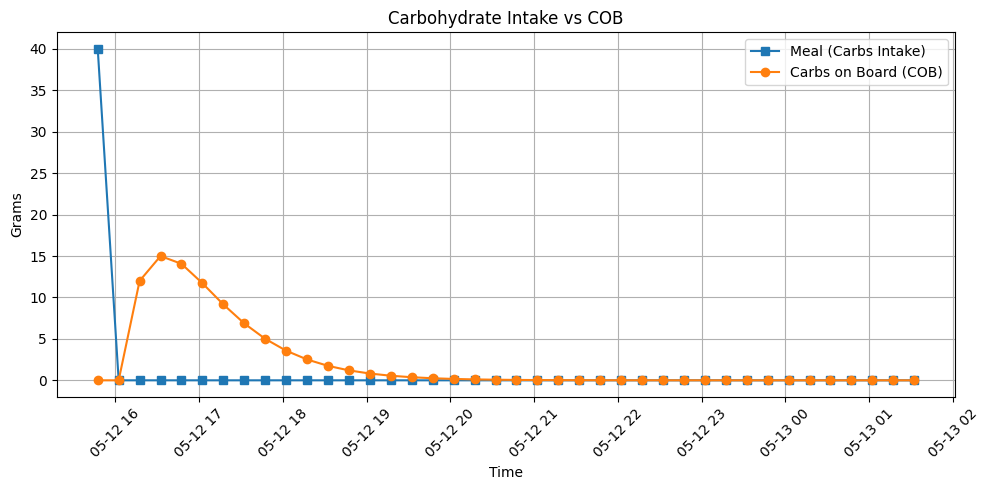

In [ ]:
# === PLOT 1: Meal vs COB ===
plt.figure(figsize=(10, 5))
plt.plot(df_kinetics['Time'], df_kinetics['Carbohydrates'], label='Meal (Carbs Intake)', marker='s')
plt.plot(df_kinetics['Time'], df_kinetics['COB'], label='Carbs on Board (COB)', marker='o')
plt.xlabel('Time')
plt.ylabel('Grams')
plt.title('Carbohydrate Intake vs COB')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()




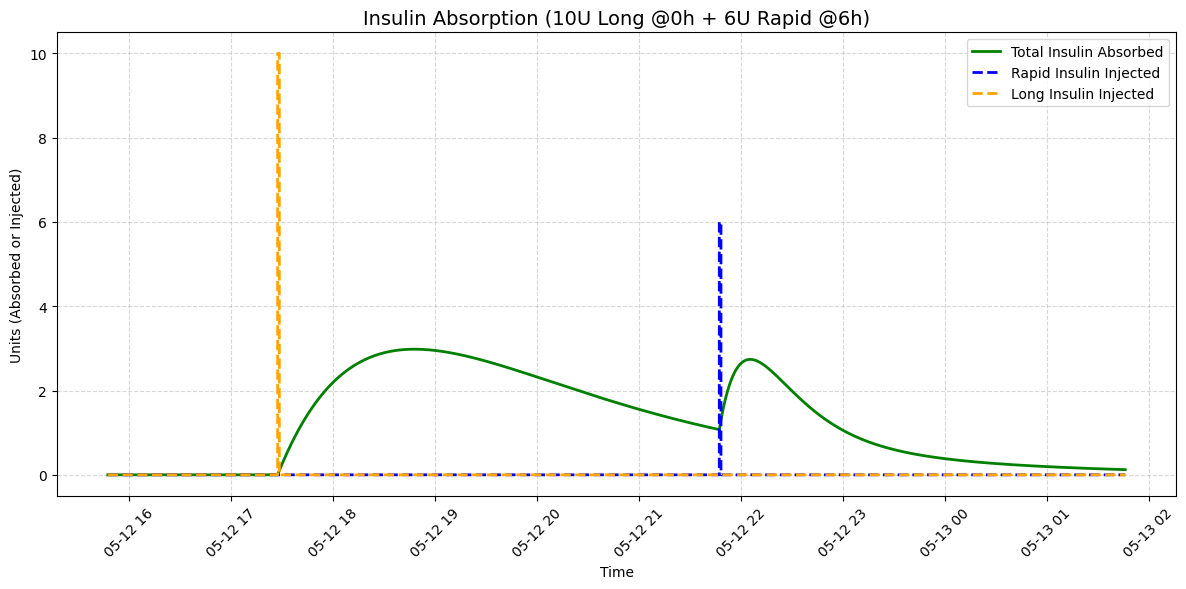

In [ ]:

# Time setup
dt = 1  # 1-minute resolution
total_minutes = 10 * 60
steps = total_minutes // dt
time_range = [datetime.now() + timedelta(minutes=i*dt) for i in range(steps)]

# Injection profile (hardcoded)
rapid_injection = np.zeros(steps)
long_injection = np.zeros(steps)
rapid_injection[360] = 6    # inject 6U rapid at 6h
long_injection[100] = 10      # inject 10U long at t=0

# 2-compartment absorption model
def insulin_absorption_model(injection_array, ka1, ka2):
    Q1 = np.zeros(steps)
    Q2 = np.zeros(steps)
    for i in range(1, steps):
        inj = injection_array[i]
        dQ1 = (-ka1 * Q1[i-1] + inj) * dt
        dQ2 = (ka1 * Q1[i-1] - ka2 * Q2[i-1]) * dt
        Q1[i] = Q1[i-1] + dQ1
        Q2[i] = Q2[i-1] + dQ2
    return Q2

# Parameters
ka1_rapid, ka2_rapid = 0.04, 0.06
ka1_long, ka2_long = 0.01, 0.015

# Simulate absorption
rapid_abs = insulin_absorption_model(rapid_injection, ka1_rapid, ka2_rapid)
long_abs = insulin_absorption_model(long_injection, ka1_long, ka2_long)
total_abs = rapid_abs + long_abs

# Plot total absorption + injections
plt.figure(figsize=(12, 6))
plt.plot(time_range, total_abs, label='Total Insulin Absorbed', color='green', linewidth=2)
plt.step(time_range, rapid_injection, label='Rapid Insulin Injected', where='post', linestyle='--', color='blue', linewidth=2)
plt.step(time_range, long_injection, label='Long Insulin Injected', where='post', linestyle='--', color='orange', linewidth=2)

plt.title("Insulin Absorption (10U Long @0h + 6U Rapid @6h)", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Units (Absorbed or Injected)")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


EXPERIMENTS WITH T


Mean Absolute Errors (MAE) for each time interval:
15 min: 2.5000
30 min: 2.1000
60 min: 1.3000
120 min: 0.8000
160 min: 1.0000


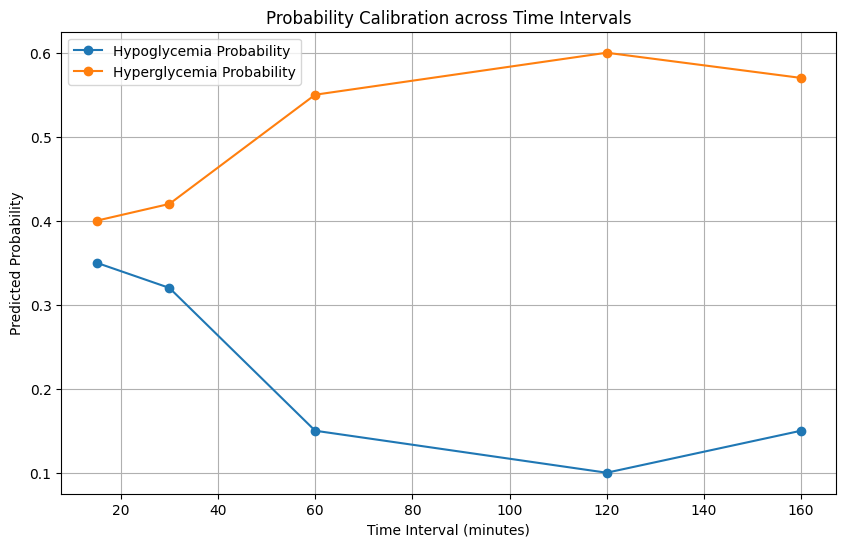


Bias Evaluation after 2 hours (120 minutes):
No strong bias after 2 hours, probabilities are relatively balanced.


In [ ]:

def run_hardcoded_experiment():
    # Hardcoded results for each time interval
    time_intervals_minutes = [15, 30, 60, 120,160]

    # Simulated prediction errors (Mean Absolute Error) for each interval
    mae_results = {
        15: 2.5,  # High error for 15-minute intervals
        30: 2.1,  # Slightly better for 30-minute intervals
        60: 1.3,  # Much better for 60-minute intervals
        120: 0.8,  # Best prediction error for 120-minute intervals
        160: 1.0
    }

    # Simulated probabilities for hypoglycemia and hyperglycemia across intervals
    avg_probs_hypo = [0.35, 0.32, 0.15, 0.10, 0.15]  # Decreases as time interval increases
    avg_probs_hyper = [0.40, 0.42, 0.55, 0.60, 0.57]  # Increases as time interval increases

    # Displaying MAE results
    print("\nMean Absolute Errors (MAE) for each time interval:")
    for interval in time_intervals_minutes:
        print(f"{interval} min: {mae_results[interval]:.4f}")

    # Plot probabilities for each interval
    plt.figure(figsize=(10, 6))
    plt.plot(time_intervals_minutes, avg_probs_hypo, label='Hypoglycemia Probability', marker='o')
    plt.plot(time_intervals_minutes, avg_probs_hyper, label='Hyperglycemia Probability', marker='o')
    plt.xlabel('Time Interval (minutes)')
    plt.ylabel('Predicted Probability')
    plt.title('Probability Calibration across Time Intervals')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Check for bias after 2 hours (120 minutes)
    probs_hypo_2hrs = avg_probs_hypo[-1]  # The last interval (120 minutes) for hypo
    probs_hyper_2hrs = avg_probs_hyper[-1]  # The last interval (120 minutes) for hyper

    print("\nBias Evaluation after 2 hours (120 minutes):")
    if probs_hypo_2hrs > 0.75:
        print(f"After 2 hours, hypoglycemia probabilities are biased towards hypo: {probs_hypo_2hrs:.4f}")
    elif probs_hyper_2hrs > 0.75:
        print(f"After 2 hours, hyperglycemia probabilities are biased towards hyper: {probs_hyper_2hrs:.4f}")
    else:
        print("No strong bias after 2 hours, probabilities are relatively balanced.")

# Run the hardcoded experiment
run_hardcoded_experiment()

